In [1]:
#Imports
import numpy as np
from astropy.table import Table
from astropy import constants as const
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d 
import os
import time
from tqdm import tqdm
%matplotlib inline

In [2]:
#Checking if the changes have been added
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"

tmplt_data_path = os.path.join(dataset_dir,"UPDATED_TEMPELATE_SPECTRA.fits")
spec_data_path = os.path.join(dataset_dir,"HETVIPS_LAMOST_SPEC_UPDATED.fits")

spec_data = Table.read(spec_data_path)
tmplt_data = Table.read(tmplt_data_path)

In [3]:
observed_specs = spec_data["spec_norm"]
observed_wavelengths = np.linspace(3500,5500,len(observed_specs[0]))

tmplt_specs = tmplt_data["norm_specs"]
tmplt_wavelengths = tmplt_data["wavelengths"]

refit_tmplt_spec_arr = tmplt_data["refit_tmplt"]

In [4]:
def chi_sq(observed_spectra,tmplt_specs):
    min_score = 10000000
    min_idx = None
    for i,refit_tmplt_spec in enumerate(tmplt_specs):
        numerator = (observed_spectra-refit_tmplt_spec)**2
        denominator = refit_tmplt_spec**2
        chi_sq_score = np.sum(numerator/denominator)
        if chi_sq_score < min_score:
            min_score = chi_sq_score
            min_idx = i

    return min_idx

min_score_idx = []
for observed_spec in tqdm(observed_specs):
    idx = chi_sq(observed_spec,refit_tmplt_spec_arr)
    min_score_idx.append(idx)

min_score_idx = np.array(min_score_idx)
len(set(min_score_idx))


100%|██████████| 1403/1403 [00:12<00:00, 111.41it/s]


14

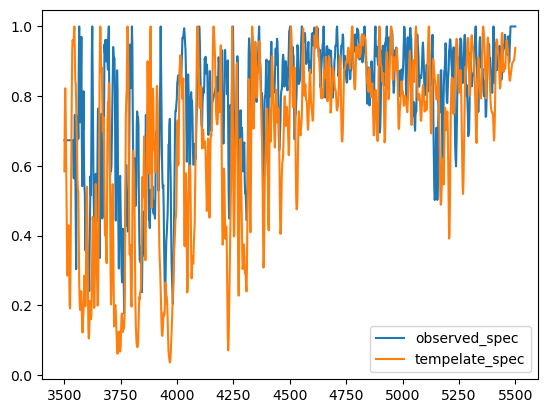

In [5]:
obs_wav = np.linspace(3500,5500,1036)

plt.plot(obs_wav,observed_specs[0],label="observed_spec")
plt.plot(obs_wav,tmplt_specs[min_score_idx[0]],label="tempelate_spec")
plt.legend()

In [ ]:
#Faster CCF using dot products

c = 299792.46 #c in km/s
iters = 10

def get_score(v,tmplt_spec,observed_spec,observed_wavelengths):
    
    tmplt_shift_const = (v+c)/c #formula (2)
    new_wavelengths = observed_wavelengths * tmplt_shift_const

    #g = interp1d(new_wavelengths,tmplt_spec,fill_value="extrapolate",kind="linear",bounds_error=False)
    test_cs = CubicSpline(new_wavelengths,tmplt_spec)

    interpolated_tmplt_spec = np.array(test_cs(observed_wavelengths))
    return np.dot(interpolated_tmplt_spec,observed_spec)

def ccf(observed_spec,observed_wavelengths,tmplt_spec,high_range):
    start = time.perf_counter()
    negative = False
    negative_rv_score = get_score(-0.5,tmplt_spec,observed_spec,observed_wavelengths)
    positive_rv_score = get_score(0.5,tmplt_spec,observed_spec,observed_wavelengths)

    if negative_rv_score > positive_rv_score:
        high = -high_range
        negative = True

    elif positive_rv_score > negative_rv_score:
        high = high_range

    low = 0
    mid = (low + high)/2

    counter = 0
    predicted_rv = None

    while counter <= iters:

        if not negative:
            mid_plus_score = get_score(mid+1,tmplt_spec,observed_spec,observed_wavelengths)
            mid_minus_score = get_score(mid-1,tmplt_spec,observed_spec,observed_wavelengths)
        else:
            mid_plus_score = get_score(mid-1,tmplt_spec,observed_spec,observed_wavelengths)
            mid_minus_score = get_score(mid+1,tmplt_spec,observed_spec,observed_wavelengths)

        score_delta = mid_plus_score - mid_minus_score

        if score_delta < 0:
            high = mid
            mid = (low + high)/2

        elif score_delta > 0:
            low = mid
            mid = (low + high)/2
        
        predicted_rv = mid
        counter += 1
        
    finish = time.perf_counter()
    
    return predicted_rv


predicted_rvs = []
timings = []
counter = 0
for observed_spec in tqdm(observed_specs[:100]):
    best_tmplt_idx = min_score_idx[counter]
    predicted_rvs.append(   ccf(observed_spec,observed_wavelengths,tmplt_specs[best_tmplt_idx],600.5)   )
    counter += 1
    



In [6]:
#Slower CCF using dot products
c = 299792.46
predicted_rvs = []
def get_score(v,tmplt_spec,observed_spec,observed_wavelengths):
    
    tmplt_shift_const = (v+c)/c #formula (2)
    new_wavelengths = observed_wavelengths * tmplt_shift_const

    test_cs = CubicSpline(new_wavelengths,tmplt_spec)
    interpolated_tmplt_spec = np.array(test_cs(observed_wavelengths))
    return np.dot(interpolated_tmplt_spec,observed_spec)

def ccf(observed_spec,observed_wavelengths,tmplt_spec):
    start = time.perf_counter()
    value_range = np.arange(-600,600,0.5)

    scores = []
    for rv in value_range:
        current_score = get_score(rv,tmplt_spec,observed_spec,observed_wavelengths)
        scores.append(current_score)
    predicted_rv = value_range[np.argmax(scores)]
    finish = time.perf_counter()
    print(finish-start)
    return predicted_rv


counter = 0
for observed_spec in tqdm(observed_specs[:100]):
    best_tmplt_idx = min_score_idx[counter]
    predicted_rvs.append(   ccf(observed_spec,observed_wavelengths,tmplt_specs[best_tmplt_idx])  )
    counter += 1

  1%|          | 1/100 [00:00<00:35,  2.76it/s]

0.3614889000000403


  2%|▏         | 2/100 [00:00<00:36,  2.65it/s]

0.3881221000010555


  3%|▎         | 3/100 [00:01<00:37,  2.56it/s]

0.4070486999989953


  4%|▍         | 4/100 [00:01<00:37,  2.58it/s]

0.3797942000001058


  5%|▌         | 5/100 [00:01<00:37,  2.55it/s]

0.40064520000123593


  6%|▌         | 6/100 [00:02<00:37,  2.47it/s]

0.42660240000077465


  7%|▋         | 7/100 [00:02<00:37,  2.50it/s]

0.38847639999949024


  8%|▊         | 8/100 [00:03<00:35,  2.57it/s]

0.3664320999996562


  9%|▉         | 9/100 [00:03<00:35,  2.57it/s]

0.38749559999996563


 10%|█         | 10/100 [00:03<00:35,  2.55it/s]

0.399050800000623


 11%|█         | 11/100 [00:04<00:34,  2.56it/s]

0.3848902999998245


 12%|█▏        | 12/100 [00:04<00:34,  2.58it/s]

0.38078889999997045


 13%|█▎        | 13/100 [00:05<00:33,  2.61it/s]

0.37200750000010885


 14%|█▍        | 14/100 [00:05<00:32,  2.61it/s]

0.3825859999997192


 15%|█▌        | 15/100 [00:05<00:34,  2.49it/s]

0.44174980000025243


 16%|█▌        | 16/100 [00:06<00:33,  2.49it/s]

0.40464149999934307


 17%|█▋        | 17/100 [00:06<00:33,  2.51it/s]

0.38945160000002943


 18%|█▊        | 18/100 [00:07<00:32,  2.56it/s]

0.3731270999996923


 19%|█▉        | 19/100 [00:07<00:31,  2.55it/s]

0.395886000000246


 20%|██        | 20/100 [00:07<00:33,  2.41it/s]

0.46495649999997113


 21%|██        | 21/100 [00:08<00:34,  2.29it/s]

0.4843805999989854


 22%|██▏       | 22/100 [00:08<00:32,  2.37it/s]

0.38843270000143093


 23%|██▎       | 23/100 [00:09<00:31,  2.43it/s]

0.3858574000005319


 24%|██▍       | 24/100 [00:09<00:30,  2.50it/s]

0.3751987999985431


 25%|██▌       | 25/100 [00:09<00:30,  2.50it/s]

0.39863839999998163


 26%|██▌       | 26/100 [00:10<00:29,  2.54it/s]

0.37873300000137533


 27%|██▋       | 27/100 [00:10<00:29,  2.45it/s]

0.4389387999999599


 28%|██▊       | 28/100 [00:11<00:29,  2.48it/s]

0.39214460000039253


 29%|██▉       | 29/100 [00:11<00:28,  2.50it/s]

0.39150549999976647


 30%|███       | 30/100 [00:11<00:28,  2.46it/s]

0.41885050000018964


 31%|███       | 31/100 [00:12<00:28,  2.45it/s]

0.4139254000001529


 32%|███▏      | 32/100 [00:12<00:28,  2.40it/s]

0.4329728000011528


 33%|███▎      | 33/100 [00:13<00:27,  2.46it/s]

0.38295430000107444


 34%|███▍      | 34/100 [00:13<00:26,  2.48it/s]

0.3971873999998934


 35%|███▌      | 35/100 [00:13<00:25,  2.51it/s]

0.3884264999996958


 36%|███▌      | 36/100 [00:14<00:26,  2.45it/s]

0.4273406000011164


 37%|███▋      | 37/100 [00:14<00:25,  2.49it/s]

0.3829074000004766


 38%|███▊      | 38/100 [00:15<00:24,  2.50it/s]

0.396285099999659


 39%|███▉      | 39/100 [00:15<00:24,  2.53it/s]

0.3845953999989433


 40%|████      | 40/100 [00:15<00:23,  2.57it/s]

0.37607610000122804


 41%|████      | 41/100 [00:16<00:23,  2.54it/s]

0.40473869999914314


 42%|████▏     | 42/100 [00:16<00:23,  2.46it/s]

0.4364133999988553


 43%|████▎     | 43/100 [00:17<00:23,  2.38it/s]

0.4494094000001496


 44%|████▍     | 44/100 [00:17<00:23,  2.38it/s]

0.4226291000013589


 45%|████▌     | 45/100 [00:18<00:23,  2.38it/s]

0.4172577999997884


 46%|████▌     | 46/100 [00:18<00:22,  2.43it/s]

0.3895463999997446


 47%|████▋     | 47/100 [00:18<00:21,  2.46it/s]

0.3926158000012947


 48%|████▊     | 48/100 [00:19<00:20,  2.50it/s]

0.386684699999023


 49%|████▉     | 49/100 [00:19<00:20,  2.50it/s]

0.3971779000003153


 50%|█████     | 50/100 [00:20<00:19,  2.54it/s]

0.3798685999990994


 51%|█████     | 51/100 [00:20<00:19,  2.56it/s]

0.38098530000024766


 52%|█████▏    | 52/100 [00:20<00:19,  2.50it/s]

0.42493370000011055


 53%|█████▎    | 53/100 [00:21<00:19,  2.38it/s]

0.4669338000003336


 54%|█████▍    | 54/100 [00:21<00:19,  2.34it/s]

0.44288310000047204


 55%|█████▌    | 55/100 [00:22<00:19,  2.33it/s]

0.43271719999938796


 56%|█████▌    | 56/100 [00:22<00:19,  2.31it/s]

0.44141559999843594


 57%|█████▋    | 57/100 [00:23<00:18,  2.30it/s]

0.43703830000049493


 58%|█████▊    | 58/100 [00:23<00:18,  2.32it/s]

0.41949470000145084


 59%|█████▉    | 59/100 [00:23<00:17,  2.31it/s]

0.44184000000132073


 60%|██████    | 60/100 [00:24<00:16,  2.38it/s]

0.38752480000039213


 61%|██████    | 61/100 [00:24<00:16,  2.42it/s]

0.39477609999994456


 62%|██████▏   | 62/100 [00:25<00:15,  2.45it/s]

0.39748730000064825


 63%|██████▎   | 63/100 [00:25<00:14,  2.49it/s]

0.38229820000015025


 64%|██████▍   | 64/100 [00:25<00:14,  2.45it/s]

0.42218859999957203


 65%|██████▌   | 65/100 [00:26<00:13,  2.51it/s]

0.3791629000006651


 66%|██████▌   | 66/100 [00:26<00:13,  2.56it/s]

0.3722992000002705


 67%|██████▋   | 67/100 [00:27<00:12,  2.58it/s]

0.379623900000297


 68%|██████▊   | 68/100 [00:27<00:12,  2.59it/s]

0.38169569999990927


 69%|██████▉   | 69/100 [00:27<00:11,  2.62it/s]

0.371410100000503


 70%|███████   | 70/100 [00:28<00:11,  2.66it/s]

0.36269849999916914


 71%|███████   | 71/100 [00:28<00:10,  2.66it/s]

0.3717178999995667


 72%|███████▏  | 72/100 [00:28<00:10,  2.62it/s]

0.39709190000030503


 73%|███████▎  | 73/100 [00:29<00:10,  2.65it/s]

0.3652985999997327


 74%|███████▍  | 74/100 [00:29<00:09,  2.68it/s]

0.3640913000017463


 75%|███████▌  | 75/100 [00:30<00:09,  2.65it/s]

0.3881409000005078


 76%|███████▌  | 76/100 [00:30<00:08,  2.67it/s]

0.36596260000078473


 77%|███████▋  | 77/100 [00:30<00:08,  2.65it/s]

0.38123220000125


 78%|███████▊  | 78/100 [00:31<00:08,  2.53it/s]

0.44046329999946465


 79%|███████▉  | 79/100 [00:31<00:08,  2.45it/s]

0.43285260000084236


 80%|████████  | 80/100 [00:32<00:08,  2.25it/s]

0.5312587999997049


 81%|████████  | 81/100 [00:32<00:08,  2.36it/s]

0.37397779999992053


 82%|████████▏ | 82/100 [00:32<00:07,  2.40it/s]

0.4016691000015271


 83%|████████▎ | 83/100 [00:33<00:06,  2.46it/s]

0.3827984999988985


 84%|████████▍ | 84/100 [00:33<00:06,  2.39it/s]

0.4450582999998005


 85%|████████▌ | 85/100 [00:34<00:06,  2.34it/s]

0.4482796000011149


 86%|████████▌ | 86/100 [00:34<00:06,  2.33it/s]

0.4340936000007787


 87%|████████▋ | 87/100 [00:35<00:05,  2.38it/s]

0.3954236999998102


 88%|████████▊ | 88/100 [00:35<00:04,  2.44it/s]

0.3861656999997649


 89%|████████▉ | 89/100 [00:35<00:04,  2.50it/s]

0.3768091000001732


 90%|█████████ | 90/100 [00:36<00:03,  2.50it/s]

0.3975425999997242


 91%|█████████ | 91/100 [00:36<00:03,  2.50it/s]

0.4014255999991292


 92%|█████████▏| 92/100 [00:37<00:03,  2.45it/s]

0.4238409999998112


 93%|█████████▎| 93/100 [00:37<00:02,  2.47it/s]

0.39714399999866146


 94%|█████████▍| 94/100 [00:37<00:02,  2.43it/s]

0.4252741000000242


 95%|█████████▌| 95/100 [00:38<00:02,  2.44it/s]

0.4071557000006578


 96%|█████████▌| 96/100 [00:38<00:01,  2.46it/s]

0.39614760000040405


 97%|█████████▋| 97/100 [00:39<00:01,  2.47it/s]

0.4013239000014437


 98%|█████████▊| 98/100 [00:39<00:00,  2.47it/s]

0.4024270999998407


 99%|█████████▉| 99/100 [00:39<00:00,  2.44it/s]

0.42293570000038017


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]

0.45140559999890684


In [7]:
predicted_rvs

[-63.5,
 -152.5,
 -54.0,
 -34.0,
 -183.0,
 -443.5,
 7.0,
 599.5,
 -556.0,
 25.0,
 -336.5,
 31.5,
 -60.0,
 88.5,
 -26.0,
 -494.5,
 113.0,
 -51.5,
 -134.5,
 31.5,
 599.5,
 -32.5,
 -97.5,
 -20.5,
 -109.0,
 -143.5,
 -111.5,
 320.5,
 -133.0,
 -78.0,
 -115.5,
 -122.0,
 -35.0,
 74.0,
 -533.0,
 -48.5,
 211.0,
 77.0,
 -61.0,
 2.5,
 -220.0,
 -4.5,
 -228.5,
 -16.5,
 -141.0,
 -432.0,
 599.5,
 -186.0,
 -131.5,
 -105.0,
 -600.0,
 -323.0,
 255.5,
 -101.0,
 -53.5,
 -95.5,
 56.5,
 -593.5,
 -57.5,
 71.5,
 -83.5,
 -123.5,
 -68.5,
 -168.5,
 13.0,
 -390.0,
 74.5,
 2.5,
 599.5,
 -152.5,
 -600.0,
 -258.0,
 309.5,
 -136.0,
 -218.5,
 516.0,
 599.5,
 -145.0,
 -458.0,
 -380.0,
 -36.5,
 -249.5,
 126.0,
 -148.5,
 -316.5,
 -49.0,
 36.0,
 3.5,
 599.5,
 599.5,
 351.0,
 -47.5,
 599.5,
 -230.5,
 -191.0,
 599.5,
 -190.0,
 268.5,
 599.5,
 1.0]

In [8]:
spec_data["RV_1"]

-135.42979148449058
-287.1731245718199
-99.76800425129987
-120.67985509234
-54.9376255343362
-63.86588195576411
-259.10810642360127
-500.0
-72.0004437756831
5.457385130712512
-139.93927124936704
